# 🧙‍♂️ Sample Generation with Pretrained Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebook.ipynb)

### Initial setup ⚙️

In [1]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Repository 'PML_DL_Final_Project' already exists. Skipping clone.


In [2]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [3]:
import torch
import numpy as np

from src.train.train import train
from src.utils.data import get_dataloaders
from src.models.diffusion import Diffusion
from src.utils.plots import plot_image_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🛠️ Configuration Parameters

In [4]:
epochs = 20
batch_size = 128
learning_rate = 2e-3
seed = 1337
checkpoint = None  # e.g., "checkpoints/last.ckpt"
model_name = "unet"
method = "diffusion"  # or "flow"

### 🧪 Setup: Seed and Device

In [5]:
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 🧠 Model Training

#### 📥 Data Loading

In [6]:
train_loader, val_loader = get_dataloaders(batch_size=batch_size)

#### Training

In [7]:
# NOTE: Currently assumes 10 classes are hardcoded
num_classes = 10
model_kwargs = {"num_classes": num_classes}

model = train(
    num_epochs=epochs,
    device=device,
    dataloader=train_loader,
    val_loader=val_loader,
    learning_rate=learning_rate,
    use_wandb=True,
    checkpoint_path=checkpoint,
    model_name=model_name,
    model_kwargs=model_kwargs,
    method=method,
)

WANDB_API_KEY environment variable not set. Please enter your WandB API key:  d8dc3ad9caae0ce9504bfcf61be898d8fbdbef18


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/20


Train Loss: 0.0873 | Val Loss: 0.0572 | LR: 0.001988
New best model saved! Epoch 1, Val Loss: 0.0572

Epoch 2/20


Train Loss: 0.0537 | Val Loss: 0.0501 | LR: 0.001951
New best model saved! Epoch 2, Val Loss: 0.0501

Epoch 3/20


Train Loss: 0.0492 | Val Loss: 0.0468 | LR: 0.001892
New best model saved! Epoch 3, Val Loss: 0.0468

Epoch 4/20


Train Loss: 0.0464 | Val Loss: 0.0445 | LR: 0.001810
New best model saved! Epoch 4, Val Loss: 0.0445

Epoch 5/20


Train Loss: 0.0452 | Val Loss: 0.0439 | LR: 0.001709
New best model saved! Epoch 5, Val Loss: 0.0439

Epoch 6/20


Train Loss: 0.0443 | Val Loss: 0.0433 | LR: 0.001590
New best model saved! Epoch 6, Val Loss: 0.0433

Epoch 7/20


Train Loss: 0.0433 | Val Loss: 0.0427 | LR: 0.001457
New best model saved! Epoch 7, Val Loss: 0.0427

Epoch 8/20


Train Loss: 0.0433 | Val Loss: 0.0442 | LR: 0.001312

Epoch 9/20


Train Loss: 0.0423 | Val Loss: 0.0418 | LR: 0.001161
New best model saved! Epoch 9, Val Loss: 0.0418

Epoch 10/20


Train Loss: 0.0416 | Val Loss: 0.0419 | LR: 0.001005

Epoch 11/20


Train Loss: 0.0414 | Val Loss: 0.0426 | LR: 0.000849

Epoch 12/20


Train Loss: 0.0413 | Val Loss: 0.0398 | LR: 0.000698
New best model saved! Epoch 12, Val Loss: 0.0398

Epoch 13/20


Train Loss: 0.0406 | Val Loss: 0.0401 | LR: 0.000553

Epoch 14/20


Train Loss: 0.0403 | Val Loss: 0.0392 | LR: 0.000420
New best model saved! Epoch 14, Val Loss: 0.0392

Epoch 15/20


Train Loss: 0.0401 | Val Loss: 0.0398 | LR: 0.000301

Epoch 16/20


Train Loss: 0.0394 | Val Loss: 0.0390 | LR: 0.000200
New best model saved! Epoch 16, Val Loss: 0.0390

Epoch 17/20


Train Loss: 0.0396 | Val Loss: 0.0400 | LR: 0.000118

Epoch 18/20


Train Loss: 0.0389 | Val Loss: 0.0399 | LR: 0.000059

Epoch 19/20


Train Loss: 0.0393 | Val Loss: 0.0389 | LR: 0.000022
New best model saved! Epoch 19, Val Loss: 0.0389

Epoch 20/20


Train Loss: 0.0390 | Val Loss: 0.0387 | LR: 0.000010
New best model saved! Epoch 20, Val Loss: 0.0387


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/loss_epoch,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▅▃▂▄▅▄▅▆▄▃▃▂▄▃▃▂▃▁▃▃▂▂▂▁▃▄▃▁▁▃▂▃▂▂▂▂▁▃▄
val/loss,█▅▄▃▃▃▂▃▂▂▂▁▂▁▁▁▁▁▁▁
best_train_loss,0.03905
best_val_epoch,20
best_val_loss,0.03875
best_val_lr,1e-05
epoch,20
learning_rate,1e-05



Training complete. Best validation loss: 0.0387


## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [8]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### 🔌 Load Pretrained Model

In [9]:
import wandb
num_classes = 10  # 🔢 Total number of class labels (e.g., digits 0–9 for MNIST)

model_kwargs = {
    "num_classes": num_classes,
    "time_emb_dim": 128,  # Must match training config
}

# Initialize wandb run
run = wandb.init()

# Model name as expected by your `get_model` function
model_name = "unet"
ckpt_path = "jac-zac/diffusion-project/model-epoch-24:v0"

# Load model
model = load_pretrained_model(
    model_name=model_name,
    ckpt_path=ckpt_path,
    device=device,
    model_kwargs=model_kwargs,
    wandb_run=run,
)

wandb:   1 of 1 files downloaded.  


#### 💨 Initialize Diffusion Process

Generated 5 samples with labels [0, 1, 2, 3, 4]


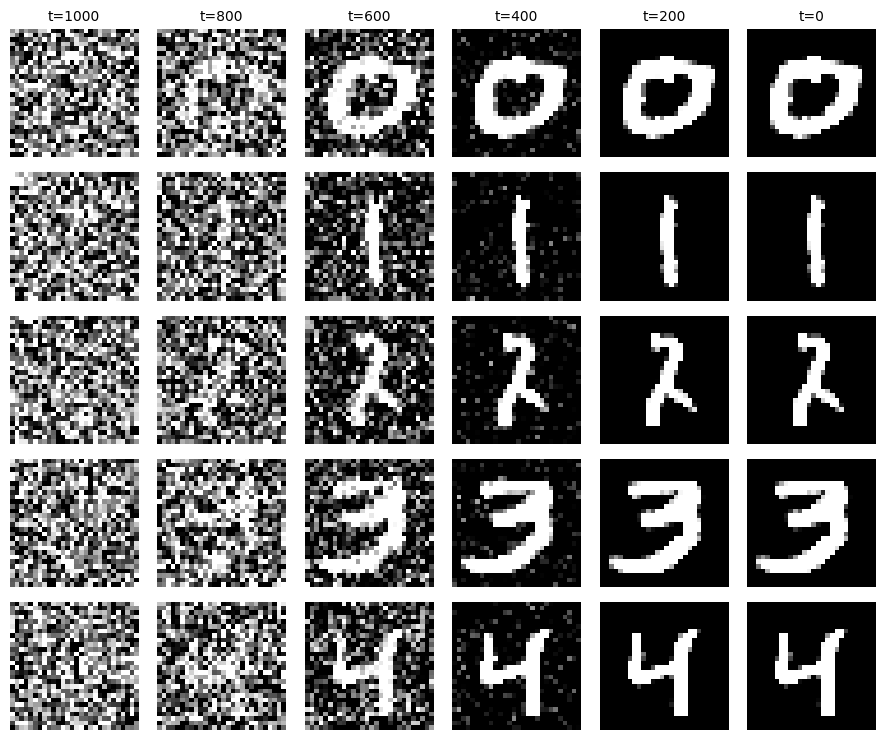

In [11]:
from PIL import Image

# 💫 Create diffusion sampler
diffusion = Diffusion(img_size=28, device=device)
plot_image_grid(
    model,
    diffusion,
    n=n_samples,
    max_steps=max_steps,
    save_dir=save_dir,
    device=device,
    num_classes=num_classes,
)

# Display the images on the notebook
out_path = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path))